<a href="https://colab.research.google.com/github/Mehak-B18068/malaria/blob/main/MalariaPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading Dataset from Kaggle

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mehak2106","key":"63f2f68d8fd5fc7115ce16356613b880"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 99% 670M/675M [00:10<00:00, 59.0MB/s]
100% 675M/675M [00:10<00:00, 65.8MB/s]


In [ ]:
!unzip cell-images-for-detecting-malaria.zip -d malaria

Distribution of images per class


In [127]:
Parasitized_count=len(os.listdir("malaria/cell_images/cell_images/Parasitized"))
Uninfected_count=len(os.listdir("malaria/cell_images/cell_images/Uninfected"))

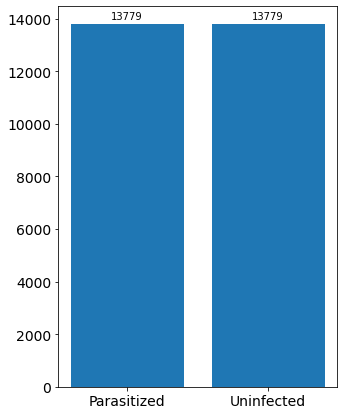

In [136]:
f, ax = plt.subplots(figsize=(5,7))
dist=ax.bar(['Parasitized','Uninfected'],[Parasitized_count,Uninfected_count],width=0.8)
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(dist)      

The dataset is equally balanced(equal no. of images for all the classes)

In [27]:
import cv2 as cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import random

In [7]:
!ls /content/malaria/cell_images/Parasitized/|head -n 5

C100P61ThinF_IMG_20150918_144104_cell_162.png
C100P61ThinF_IMG_20150918_144104_cell_163.png
C100P61ThinF_IMG_20150918_144104_cell_164.png
C100P61ThinF_IMG_20150918_144104_cell_165.png
C100P61ThinF_IMG_20150918_144104_cell_166.png


Visualizing Dataset by displaying 5 images from each class

In [124]:
def plot_image(file, gray=False,directory=None, sub=False, aspect=None):
    path = directory + file
    
    img = plt.imread(path)
    if(gray):
      plt.imshow(img,cmap="gray")
    else:
      plt.imshow(img)

#     plt.title(file)
    plt.xticks([])
    plt.yticks([])
    
    if sub:
        plt.show()
        
def plot_img_dir(directory, count=5,gray=False):
    selected_files = random.sample(os.listdir(directory), count)
    
    ncols = 5
    nrows = count//ncols if count%ncols==0 else count//ncols+1
    
    figsize=(20, ncols*nrows)

    ticksize = 14
    titlesize = ticksize + 8
    labelsize = ticksize + 5


    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)
    
    i=0
    
    for file in selected_files:        
        plt.subplot(nrows, ncols, i+1)
        path = directory + file
        plot_image(file, gray,directory, aspect=None)

        i=i+1
    
    plt.tight_layout()
    plt.show()
    
def plot_img_dir_main(directory, count=5):
    labels = os.listdir(directory)
    for label in labels:
        print(label)
        plot_img_dir(directory=directory+"/"+label+"/", count=count)

Parasitized


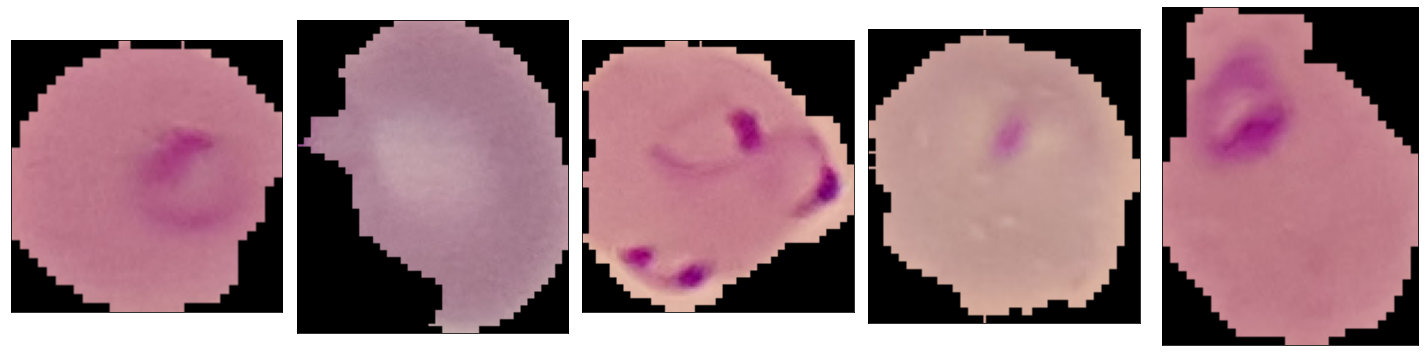

Uninfected


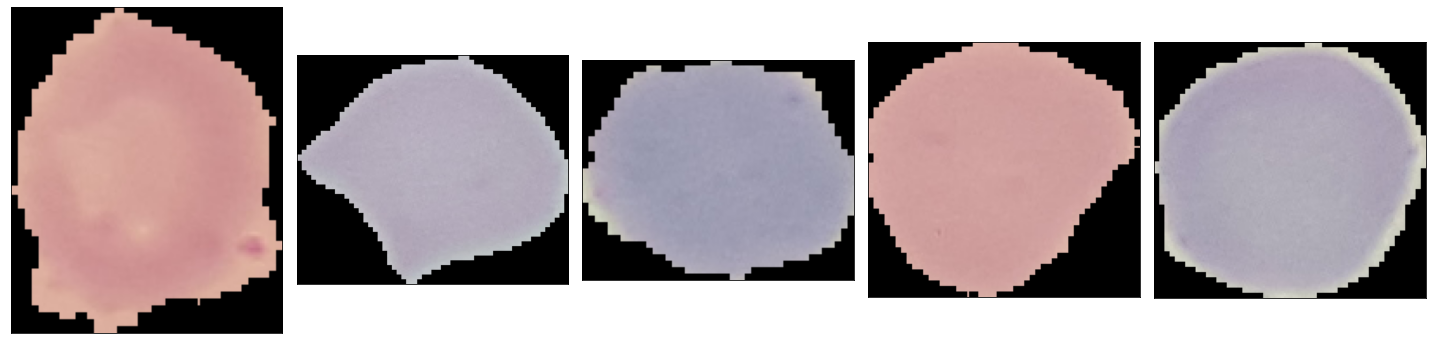

In [28]:
plot_img_dir_main("malaria/cell_images/cell_images")

Using Contrast Limited Adaptive Histogram Equalization algorithm (CLAHE) and plotting image histograms

Preprocessing first a single image to check


In [8]:
path="malaria/cell_images/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png"
img = cv2.imread(path)

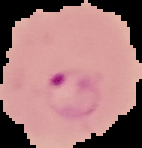

In [9]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

In [10]:
def draw_image_histogram(image, channels, color='k'):
    hist = cv2.calcHist([image], channels, None, [256], [0, 256])
    plt.plot(hist, color=color)
    plt.xlim([0, 256])

Converting into LAB color space and applying histogram equalization on the luminosity channel

In [181]:
def apply_CLAHE(image,clipLimit=40,tileGridSize=(8,8)):
  clahe = cv2.createCLAHE(clipLimit,tileGridSize)
  cl1 = clahe.apply(image)
 
  #print(cl1.shape)
  
  
  return cl1
  

In [180]:
def show_lab_equalized(image):
    L,A,B = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2LAB))
    plt.title("Image Histogram for L before applying CLAHE")
    draw_image_histogram(L,[0])
    plt.show()
    #eq_L = cv2.equalizeHist(L)
    eq_L=apply_CLAHE(L)
    plt.title("Image Histogram on applying CLAHE")
    draw_image_histogram(eq_L,[0])
    plt.show()
    eq_image = cv2.cvtColor(cv2.merge([eq_L, A, B]), cv2.COLOR_LAB2BGR)
    
    return eq_image

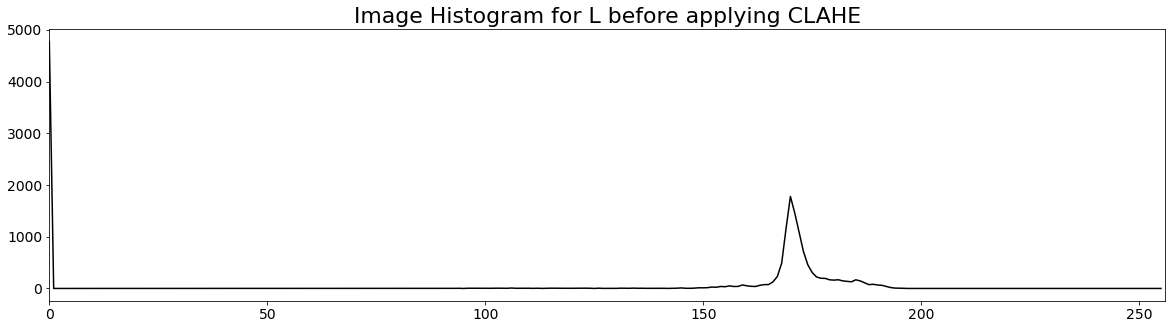

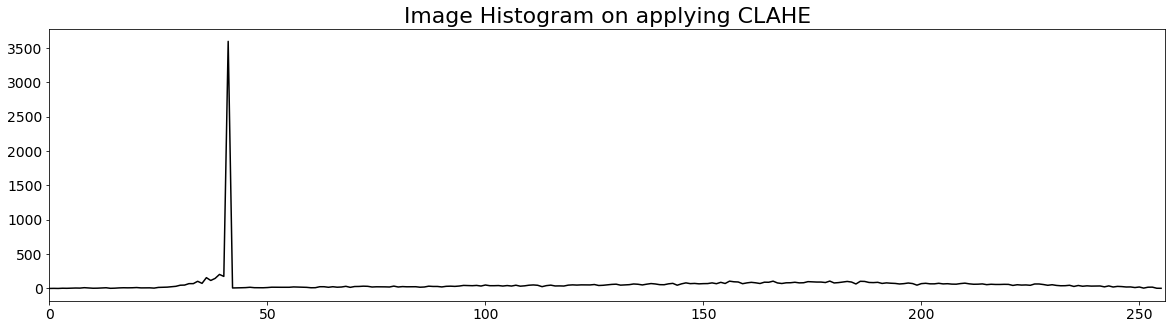

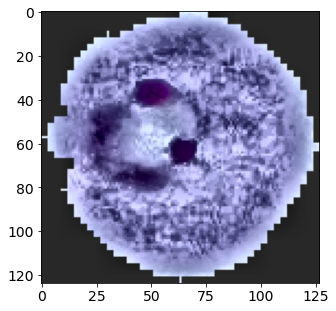

In [182]:
new_img=show_lab_equalized(img)
plt.imshow(new_img)
plt.show()

Maths behind Histogram Equalization: https://math.stackexchange.com/questions/1111795/given-an-intensity-histogram-we-apply-an-histogram-equalization-calculate-the-ne

Theory behing CLAHE
https://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html

Applying transformation on all images and saving back 

In [183]:
def transform_img(image):
  
  L,A,B = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2LAB))
  eq_L=apply_CLAHE(L)
  eq_image = cv2.cvtColor(cv2.merge([eq_L, A, B]), cv2.COLOR_LAB2BGR)
    
  return eq_image
  

In [184]:
def save_trans_img(directory,parent_directory):
    files = os.listdir(parent_directory+ '/'+directory)
      
    for file in files:
        path = parent_directory+ '/'+directory + '/'+file
        #print(path)
        img = cv2.imread(path)
        img2=transform_img(img)
        
        new_directory=parent_directory+"/new_"+directory
        #print(new_directory)
        cv2.imwrite(os.path.join(new_directory,file),img2) 
            


In [186]:
os.listdir("malaria/cell_images/cell_images/")
!rm -r malaria/cell_images/cell_images/new_Parasitized
!rm -r malaria/cell_images/cell_images/new_Uninfected
!mkdir malaria/cell_images/cell_images/new_Parasitized
!mkdir malaria/cell_images/cell_images/new_Uninfected

In [187]:
save_trans_img("Parasitized","malaria/cell_images/cell_images")
save_trans_img("Uninfected","malaria/cell_images/cell_images")

Visualizing of images after applying similar transformation

In [188]:
!ls malaria/cell_images/cell_images/new_Uninfected| tail 

C99P60ThinF_IMG_20150918_142128_cell_11.png
C99P60ThinF_IMG_20150918_142128_cell_14.png
C99P60ThinF_IMG_20150918_142128_cell_15.png
C99P60ThinF_IMG_20150918_142128_cell_3.png
C99P60ThinF_IMG_20150918_142128_cell_45.png
C99P60ThinF_IMG_20150918_142128_cell_47.png
C99P60ThinF_IMG_20150918_142128_cell_52.png
C99P60ThinF_IMG_20150918_142128_cell_53.png
C99P60ThinF_IMG_20150918_142128_cell_55.png
C99P60ThinF_IMG_20150918_142128_cell_56.png


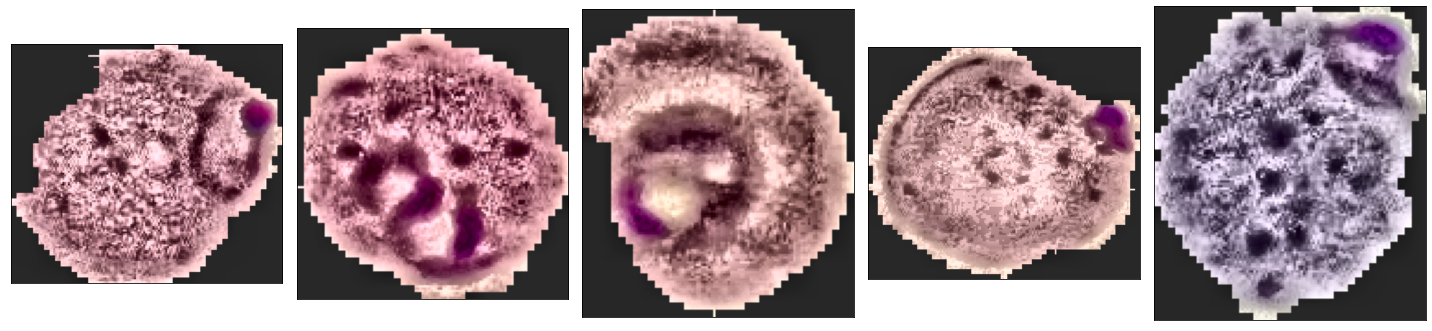

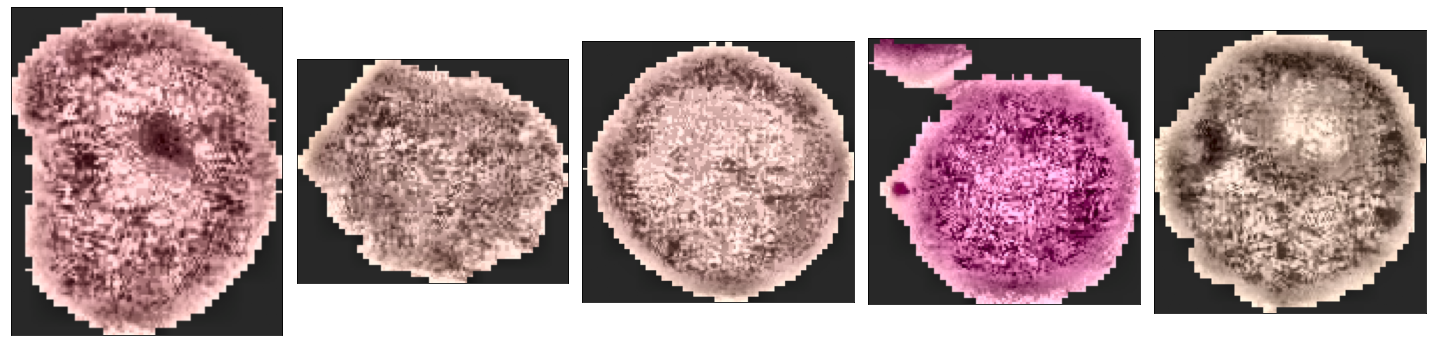

In [193]:
plt.title("Parasitized")
plot_img_dir("malaria/cell_images/cell_images/new_Parasitized/",count=5)
plt.title("Uninfected")
plot_img_dir("malaria/cell_images/cell_images/new_Uninfected/",count=5)